In [1]:
import state_space_system
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
import numpy as np
from casadi import *

from control.matlab import *
import control 

from ERA import *
from kalman_filter import *
from utils_optimization_problem import *

mpl.rcParams['font.size'] = 16 # set the matplotlib parameter

## 1. System Identification ##

In [2]:
## system identification ##

q = 2   # Number of inputs
p = 3   # Number of outputs
r = 10  # Reduced model order

time = np.linspace(0, 20, num=500)
sys = state_space_system.sys()# import real system
sys.reset()
u = np.zeros((time.shape[0]-1, 2))
u[0,0] = 1
u1 = u

u = np.zeros((time.shape[0]-1, 2))
u[0,1] = 1
u2 = u

re = 10 # repeated time for measurement
y_1 = np.zeros((time.shape[0],3))
y_2 = np.zeros((time.shape[0],3))
for n in range(re):
    y_1_t = sys.simulate(time, u1)
    # Concatenate:
    y_1_t = np.array(y_1_t)
    y_1 += y_1_t

    y_2_t = sys.simulate(time, u2)
    # Concatenate:
    y_2_t = np.array(y_2_t)
    y_2 += y_2_t
y_1 /= re
y_2 /= re
    
yFull = np.zeros((time.shape[0],p,q))

yFull[:,:,0] = y_1[:,:]
yFull[:,:,1] = y_2[:,:]

YY = np.transpose(yFull,axes=(1,2,0)) # reorder to size p x q x m 

# Compute reduced order model from impulse response
mco = int(np.floor((yFull.shape[0]-1)/2)) # m_c = m_o = (m-1)/2
Ar,Br,Cr,Dr,HSVs = ERA(YY,mco,mco,q,p,r)

# simulate the ERA system by using control package
sysERA = ss(Ar,Br,Cr,Dr,1)
y = np.zeros((time.shape[0],p,q))
for qi in range(q):
    y[:,:,qi],t = impulse(sysERA,np.arange(time.shape[0]),input=qi)

Text(0.5, 1.0, 'third mass')

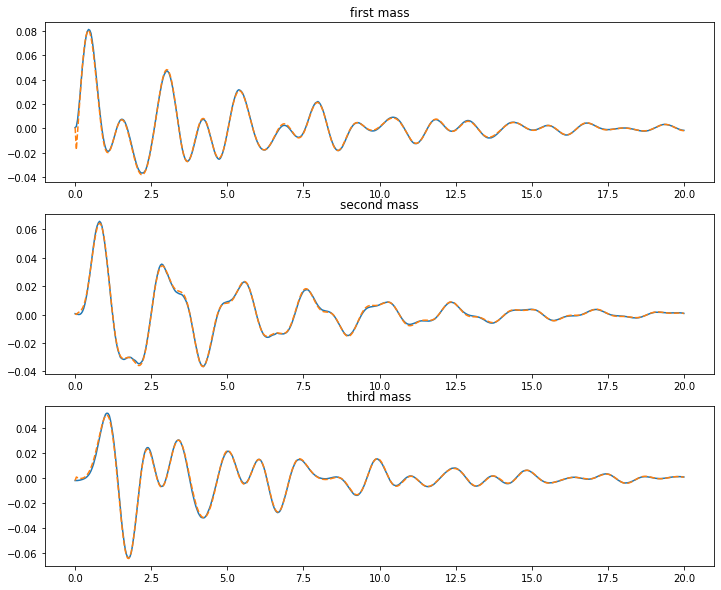

In [3]:
## ident sys. and original sys. ##
fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(12,10))
ax1.plot(time, y_1[:,0])
ax1.plot(time, y[:,0,0], '--')
ax1.set_title('first mass')
ax2.plot(time, y_1[:,1])
ax2.plot(time, y[:,1,0], '--')
ax2.set_title('second mass')
ax3.plot(time, y_1[:,2])
ax3.plot(time, y[:,2,0], '--')
ax3.set_title('third mass')

In [4]:
## Augmented system ##
Ab,Bb,Cb = augmented_system(Ar,Br,Cr)

nx = Ab.shape[1] #set the number of state and the control inputs
nu = Bb.shape[1]
ny = Cb.shape[0]

## 2. simutaneous approach ##

In [5]:
## create a symbolic expression of state space ##
x = SX.sym("x",nx,1)
delta_u = SX.sym("delta_u",nu,1)

x_next = Ab@x + Bb@delta_u
system = Function("sys",[x,delta_u],[x_next]) # Create the CasADi function

In [6]:
## MPC initialization and casadi objective function ##

Q = 10                    # make it larger to get a more aggresive controller
Q = Q*np.diag(np.ones(ny)) # the state cost mutiplyer by using the output channel: ny=3

S = Q # S for terminal cost is equal to Q

R = 1                     # set it to 1, trying to reduce the influence from the control energy term
R = np.diag(R*np.ones(nu)) # the cost of control

N = 30                     # horizon

y_Ref = SX.sym("y_ref",ny,1)   # desired trajectory

# state cost
stage_cost = (y_Ref-Cb@x).T@Q@(y_Ref-Cb@x)+ delta_u.T@R@delta_u
stage_cost_fcn = Function('stage_cost',[x,delta_u,y_Ref],[stage_cost])

# terminal cost
terminal_cost = (y_Ref-Cb@x).T@S@(y_Ref-Cb@x)
terminal_cost_fcn = Function('terminal_cost',[x,y_Ref],[terminal_cost])

In [7]:
Q[2,2] = 0
S[2,2] = 0

In [8]:
# state constraints
lb_x = -10*np.ones((nx,1))
ub_x = 10*np.ones((nx,1))
# the last two state variables is actually the control inputs
lb_x[nx-nu:] = -5
ub_x[nx-nu:] = 5
# delta_u changing rate per step constraints
lb_u = -2*np.ones((nu,1))
ub_u = 2*np.ones((nu,1))

In [9]:
## create optimization problem ##
def casadi_setting(nx,nu): # reference_signal:3*15 output*horizon
    
    X = SX.sym("X",(N+1)*nx,1)
    delta_U = SX.sym("U",N*nu,1)
    reference_signal = SX.sym("r",N,ny)

    J = 0
    lb_X = [] # lower bound for X.
    ub_X = [] # upper bound for X
    lb_U = [] # lower bound for delta_U
    ub_U = [] # upper bound for delta_U
    g = []    # constraint expression g
    lb_g = []  # lower bound for constraint expression g
    ub_g = []  # upper bound for constraint expression g
    
    for k in range(N):
        # 01 
        x_k = X[k*nx:(k+1)*nx,:]
        x_k_next = X[(k+1)*nx:(k+2)*nx,:]
        u_k = delta_U[k*nu:(k+1)*nu,:]
        # 01

        # 02 
        # objective
        J += stage_cost_fcn(x_k,u_k,reference_signal[k,:])
        # 02

        # 03 
        # equality constraints (system equation)
        x_k_next_calc = system(x_k,u_k)
        # 03

        # 04
        g.append(x_k_next - x_k_next_calc)
        lb_g.append(np.zeros((nx,1)))
        ub_g.append(np.zeros((nx,1)))
        # 04

        # 05
        lb_X.append(lb_x)
        ub_X.append(ub_x)
        lb_U.append(lb_u)
        ub_U.append(ub_u)
        # 05


    x_terminal = X[N*nx:(N+1)*nx,:]
    J += terminal_cost_fcn(x_terminal,reference_signal[-1,:])
    lb_X.append(lb_x)
    ub_X.append(ub_x)
    return lb_X,lb_U,ub_X,ub_U,X,delta_U,lb_g,ub_g,g,J,reference_signal




******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equa

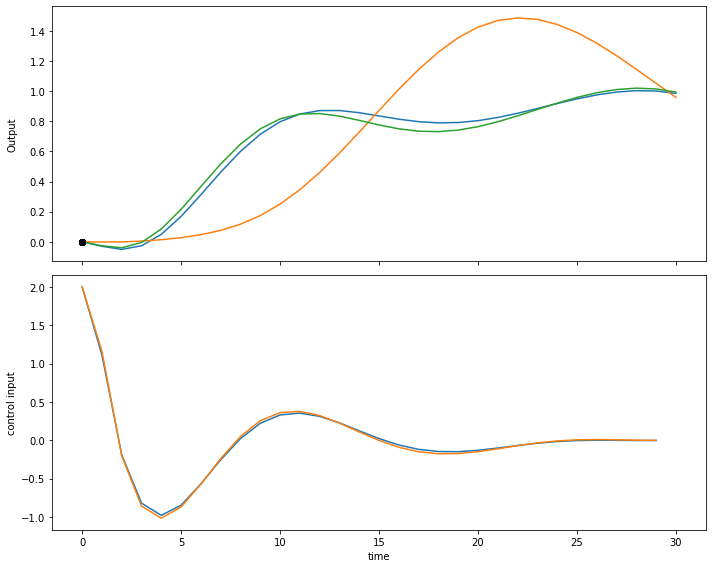

In [10]:
## test the functional solver production ##
reference = np.ones((N,ny))
lb_X,lb_U,ub_X,ub_U,X,delta_U,lb_g,ub_g,g,J,param = casadi_setting(nx,nu)
# Casadi solver
lbx = vertcat(*lb_X, *lb_U)
ubx = vertcat(*ub_X, *ub_U)
x = vertcat(X,delta_U)
g = vertcat(*g)
lbg = vertcat(*lb_g)
ubg = vertcat(*ub_g)

prob = {'f':J,'p':param,'x':x,'g':g}
solver = nlpsol('solver','ipopt',prob)

x_0 = np.zeros((nx,1))

lbx[:nx]=x_0
ubx[:nx]=x_0

res = solver(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,p=reference)

X = res['x'][:(N+1)*nx].full().reshape(N+1, nx)
delta_U = res['x'][(N+1)*nx:].full().reshape(N, nu)
Y = np.zeros((ny,1))

for n in range(N):
    temp = X[n+1].reshape(nx,1)
    Y = np.hstack((Y,Cb@temp))
    

# visulization of the result
fig, ax = plt.subplots(2,1, figsize=(10,8), sharex=True)
ax[0].plot(Y.T)
ax[1].plot(delta_U)
ax[0].set_ylabel('Output')
ax[1].set_ylabel('control input')
ax[1].set_xlabel('time')

# Highlight the selected initial state (the lines should start here!)
ax[0].plot(0,x_0.T, 'o', color='black')

fig.align_ylabels()
fig.tight_layout()

## test result looks pretty good

In [11]:
N_sim = 500 # total simulation step
time = np.linspace(0, 20, num=N_sim)
#################################### compensate for the last time step for 13 units shape:(3, 513)
REFERENCE = np.ones((ny,N_sim+N-1))
#################################### reference change test

In [12]:
%%time
## MPC main loop ##
x_0 = np.zeros((nx,1))
res_x = [x_0]
res_delta_u = []
res_u = []

## original system measurement initialization
sys.reset()
y_res = [sys.make_measurement()]

## kalman filter parameters
P_k = np.eye(Ab.shape[0],Ab.shape[1])
Q_k = np.ones((Ab.shape[0],Ab.shape[1]))
R_k = np.eye(Cb.shape[0],Cb.shape[0])

X = []

for i in range(N_sim-1):
    
    reference = REFERENCE[:,i:i+N].T
    
    lb_X,lb_U,ub_X,ub_U,X,delta_U,lb_g,ub_g,g,J,param = casadi_setting(nx,nu)
    
    # Casadi solver
    lbx = vertcat(*lb_X, *lb_U)
    ubx = vertcat(*ub_X, *ub_U)
    x = vertcat(X,delta_U)
    g = vertcat(*g)
    lbg = vertcat(*lb_g)
    ubg = vertcat(*ub_g)

    if i == 0:
        prob = {'f':J,'p':param,'x':x,'g':g}
        solver = nlpsol('solver','ipopt',prob)
    
    lbx[:nx]=x_0
    ubx[:nx]=x_0
    
    # solving the optimization problem
    res = solver(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,p=reference)
    delta_u_k = res['x'][(N+1)*nx:(N+1)*nx+nu,:].full()
    
    X = res['x'][:(N+1)*nx].full().reshape(N+1, nx)
    u_st = X[0,10:].reshape(nu,1)+ delta_u_k
    res_u.append(u_st)
    # simulate the system
    sys.simulate(time[i:i+2], (np.array(u_st)).reshape(1,2))
    
    # Append new measurement
    y_res.append(sys.make_measurement())
    
    # state Estimation
    xpred, Ppred = predict(x_0, (np.array(delta_u_k)).reshape(Bb.shape[1],1), P_k, Ab, Q_k, Bb)
    K = K_G(P_k,Cb,R_k)
    x_next,P_k = update(xpred,K,y_res[i+1],Cb,P_k,R_k,Ab)
    
    res_x.append(x_next)
    x_0 = x_next

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

   1 1.8739090e+002 1.78e-015 6.82e-001  -1.0 4.85e+000    -  5.69e-001 1.00e+000f  1
   2 1.7750514e+002 1.78e-015 7.21e-001  -1.0 5.60e-001    -  5.58e-001 1.00e+000f  1
   3 1.7709558e+002 2.66e-015 9.96e-015  -1.0 2.22e-001    -  1.00e+000 1.00e+000f  1
   4 1.7707770e+002 3.55e-015 1.07e-003  -2.5 1.35e-001    -  9.87e-001 1.00e+000f  1
   5 1.7707758e+002 5.33e-015 7.94e-015  -3.8 2.27e-002    -  1.00e+000 1.00e+000f  1
   6 1.7707758e+002 3.55e-015 9.13e-015  -5.7 2.78e-004    -  1.00e+000 1.00e+000h  1
   7 1.7707758e+002 3.55e-015 7.16e-015  -8.6 1.61e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.7707757506044760e+002   1.7707757506044760e+002
Dual infeasibility......:  7.1626950698764079e-015   7.1626950698764079e-015
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5064479869038610e-009   2.50644798690

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9.0487488e+002 4.32e+000 7.93e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 4.6893237e+001 1.78e-015 3.46e-001  -1.0 5.09e+000    -  6.60e-001 1.00e+000f  1
   2 3.9833264e+001 2.66e-015 3.28e-002  -1.0 1.08e+000    -  9.46e-001 1.00e+000f  1
   3 3.9294740e+001 1.78e-015 7.77e-003  -1.7 1.42e+000    -  9.19e-001 1.00e+000f  1
   4 3.9252536e+001 2.66e-015 5.15e-015  -2.5 5.03e-001    -  

   6 2.7757992e+001 4.44e-015 3.77e-015  -5.7 1.33e-003    -  1.00e+000 1.00e+000h  1
   7 2.7757992e+001 3.55e-015 4.25e-015  -8.6 8.00e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.7757991946406044e+001   2.7757991946406044e+001
Dual infeasibility......:  4.2465465826815537e-015   4.2465465826815537e-015
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5095069337412053e-009   2.5095069337412053e-009
Overall NLP error.......:  2.5095069337412053e-009   2.5095069337412053e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

   2 8.1608243e+000 2.22e-015 1.31e-002  -1.0 8.43e-001    -  9.78e-001 1.00e+000f  1
   3 7.9875370e+000 2.22e-015 2.43e-003  -1.7 7.87e-001    -  9.72e-001 1.00e+000f  1
   4 7.9805359e+000 3.11e-015 2.47e-015  -2.5 2.14e-001    -  1.00e+000 1.00e+000f  1
   5 7.9805031e+000 2.66e-015 3.22e-015  -3.8 1.51e-002    -  1.00e+000 1.00e+000f  1
   6 7.9805031e+000 2.66e-015 2.37e-015  -5.7 3.92e-004    -  1.00e+000 1.00e+000h  1
   7 7.9805031e+000 3.55e-015 2.75e-015  -8.6 4.06e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  7.9805031199656673e+000   7.9805031199656673e+000
Dual infeasibility......:  2.7543571209865043e-015   2.7543571209865043e-015
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5072127452828116e-009   2.5072127452828116e-009
Overall NLP error.......:  2.5072127452828116e-009   2.5072127452828116e-00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

   3 3.0733094e+000 1.78e-015 2.09e-003  -1.7 8.89e-001    -  9.72e-001 1.00e+000f  1
   4 3.0651988e+000 3.55e-015 2.36e-015  -2.5 2.29e-001    -  1.00e+000 1.00e+000f  1
   5 3.0651560e+000 3.55e-015 2.62e-015  -3.8 1.72e-002    -  1.00e+000 1.00e+000f  1
   6 3.0651560e+000 2.66e-015 3.14e-015  -5.7 4.62e-004    -  1.00e+000 1.00e+000h  1
   7 3.0651560e+000 2.66e-015 2.64e-015  -8.6 4.75e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  3.0651559814956331e+000   3.0651559814956331e+000
Dual infeasibility......:  2.6441997979818129e-015   2.6441997979818129e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5074600425338690e-009   2.5074600425338690e-009
Overall NLP error.......:  2.5074600425338690e-009   2.5074600425338690e-009


Number of objective function evaluations             = 8
Number of objective gradi

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

   1 9.6097241e+000 1.78e-015 2.69e-001  -1.0 4.38e+000    -  6.93e-001 1.00e+000f  1
   2 1.5414607e+000 2.66e-015 1.51e-002  -1.0 9.16e-001    -  9.74e-001 1.00e+000f  1
   3 1.2767503e+000 2.66e-015 3.74e-003  -1.7 9.92e-001    -  9.56e-001 1.00e+000f  1
   4 1.2639297e+000 2.66e-015 3.10e-015  -2.5 2.87e-001    -  1.00e+000 1.00e+000f  1
   5 1.2638492e+000 3.55e-015 3.15e-015  -3.8 2.39e-002    -  1.00e+000 1.00e+000f  1
   6 1.2638492e+000 2.66e-015 2.61e-015  -5.7 5.61e-004    -  1.00e+000 1.00e+000h  1
   7 1.2638492e+000 1.78e-015 3.51e-015  -8.6 5.33e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.2638491655555095e+000   1.2638491655555095e+000
Dual infeasibility......:  3.5096073250817823e-015   3.5096073250817823e-015
Constraint violation....:  1.7763568394002505e-015   1.7763568394002505e-015
Complementarity.........:  2.5077856878062985e-009   2.50778568780

   3 1.2312874e+000 3.55e-015 3.91e-003  -1.7 9.69e-001    -  9.55e-001 1.00e+000f  1
   4 1.2186778e+000 3.55e-015 2.48e-015  -2.5 2.84e-001    -  1.00e+000 1.00e+000f  1
   5 1.2185995e+000 3.55e-015 3.02e-015  -3.8 2.36e-002    -  1.00e+000 1.00e+000f  1
   6 1.2185995e+000 2.66e-015 2.56e-015  -5.7 5.49e-004    -  1.00e+000 1.00e+000h  1
   7 1.2185995e+000 3.55e-015 3.01e-015  -8.6 5.21e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.2185994570860208e+000   1.2185994570860208e+000
Dual infeasibility......:  3.0127854438256928e-015   3.0127854438256928e-015
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5077412301848515e-009   2.5077412301848515e-009
Overall NLP error.......:  2.5077412301848515e-009   2.5077412301848515e-009


Number of objective function evaluations             = 8
Number of objective gradi

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

   0 9.0005464e+002 4.41e+000 7.93e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 9.3755227e+000 2.22e-015 2.67e-001  -1.0 4.36e+000    -  6.94e-001 1.00e+000f  1
   2 1.3343354e+000 3.55e-015 1.35e-002  -1.0 8.98e-001    -  9.77e-001 1.00e+000f  1
   3 1.0925051e+000 3.55e-015 3.45e-003  -1.7 9.47e-001    -  9.59e-001 1.00e+000f  1
   4 1.0811906e+000 1.78e-015 2.95e-015  -2.5 2.70e-001    -  1.00e+000 1.00e+000f  1
   5 1.0811227e+000 2.66e-015 2.26e-015  -3.8 2.19e-002    -  1.00e+000 1.00e+000f  1
   6 1.0811227e+000 2.66e-015 2.34e-015  -5.7 5.28e-004    -  1.00e+000 1.00e+000h  1
   7 1.0811227e+000 3.55e-015 2.77e-015  -8.6 5.12e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.0811226899755446e+000   1.0811226899755446e+000
Dual infeasibility......:  2.7663175967786494e-015   2.7663175967786494e-015
Constraint violation....:  3.5527136788005009e-015   3.55

   5 1.1352609e+000 2.66e-015 2.82e-015  -3.8 2.14e-002    -  1.00e+000 1.00e+000f  1
   6 1.1352609e+000 3.55e-015 2.95e-015  -5.7 5.21e-004    -  1.00e+000 1.00e+000h  1
   7 1.1352609e+000 2.66e-015 3.58e-015  -8.6 5.08e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.1352608875358392e+000   1.1352608875358392e+000
Dual infeasibility......:  3.5757620541002213e-015   3.5757620541002213e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5076700926157176e-009   2.5076700926157176e-009
Overall NLP error.......:  2.5076700926157176e-009   2.5076700926157176e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constra

   1 9.5452850e+000 1.78e-015 2.69e-001  -1.0 4.38e+000    -  6.93e-001 1.00e+000f  1
   2 1.4928837e+000 2.66e-015 1.31e-002  -1.0 8.74e-001    -  9.78e-001 1.00e+000f  1
   3 1.2613595e+000 2.66e-015 3.23e-003  -1.7 9.21e-001    -  9.61e-001 1.00e+000f  1
   4 1.2509252e+000 3.55e-015 2.57e-015  -2.5 2.59e-001    -  1.00e+000 1.00e+000f  1
   5 1.2508650e+000 2.66e-015 3.14e-015  -3.8 2.06e-002    -  1.00e+000 1.00e+000f  1
   6 1.2508650e+000 3.55e-015 4.10e-015  -5.7 5.04e-004    -  1.00e+000 1.00e+000h  1
   7 1.2508650e+000 4.44e-015 3.05e-015  -8.6 4.95e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.2508649596986363e+000   1.2508649596986363e+000
Dual infeasibility......:  3.0540887290975030e-015   3.0540887290975030e-015
Constraint violation....:  4.4408920985006262e-015   4.4408920985006262e-015
Complementarity.........:  2.5076047921683547e-009   2.50760479216

   7 1.2881525e+000 3.55e-015 2.52e-015  -8.6 4.85e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.2881525199376900e+000   1.2881525199376900e+000
Dual infeasibility......:  2.5198144919851766e-015   2.5198144919851766e-015
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5075504661537176e-009   2.5075504661537176e-009
Overall NLP error.......:  2.5075504661537176e-009   2.5075504661537176e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9.0007190e+002 4.43e+000 7.93e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 9.3552425e+000 1.78e-015 2.68e-001  -1.0 4.37e+000    -  6.94e-001 1.00e+000f  1
   2 1.4506923e+000 1.78e-015 1.30e-002  -1.0 8.54e-001    -  9.78e-001 1.00e+000f  1
   3 1.2302349e+000 2.66e-015 3.00e-003  -1.7 9.01e-001    -  9.63e-001 1.00e+000f  1
   4 1.2205178e+000 2.66e-015 2.50e-015  -2.5 2.50e-001    -  

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9.0003686e+002 4.39e+000 7.93e+000  -1.0 0.00e+000    -  0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

   5 1.2998958e+000 2.66e-015 2.60e-015  -3.8 2.26e-002    -  1.00e+000 1.00e+000f  1
   6 1.2998958e+000 3.55e-015 2.70e-015  -5.7 5.44e-004    -  1.00e+000 1.00e+000h  1
   7 1.2998958e+000 3.55e-015 3.86e-015  -8.6 5.25e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.2998957910935303e+000   1.2998957910935303e+000
Dual infeasibility......:  3.8568307470563496e-015   3.8568307470563496e-015
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5077235443715058e-009   2.5077235443715058e-009
Overall NLP error.......:  2.5077235443715058e-009   2.5077235443715058e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constra

   2 1.6628640e+000 2.66e-015 1.56e-002  -1.0 8.98e-001    -  9.74e-001 1.00e+000f  1
   3 1.4113135e+000 2.66e-015 3.64e-003  -1.7 9.65e-001    -  9.57e-001 1.00e+000f  1
   4 1.3991956e+000 2.66e-015 2.19e-015  -2.5 2.79e-001    -  1.00e+000 1.00e+000f  1
   5 1.3991220e+000 2.66e-015 3.77e-015  -3.8 2.28e-002    -  1.00e+000 1.00e+000f  1
   6 1.3991219e+000 2.66e-015 3.37e-015  -5.7 5.40e-004    -  1.00e+000 1.00e+000h  1
   7 1.3991219e+000 3.55e-015 2.42e-015  -8.6 5.18e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.3991219389739822e+000   1.3991219389739822e+000
Dual infeasibility......:  2.4155809997762265e-015   2.4155809997762265e-015
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5077020200688539e-009   2.5077020200688539e-009
Overall NLP error.......:  2.5077020200688539e-009   2.5077020200688539e-00

   3 1.3060903e+000 4.44e-015 3.47e-003  -1.7 9.33e-001    -  9.59e-001 1.00e+000f  1
   4 1.2949454e+000 1.78e-015 2.82e-015  -2.5 2.68e-001    -  1.00e+000 1.00e+000f  1
   5 1.2948805e+000 2.66e-015 2.12e-015  -3.8 2.14e-002    -  1.00e+000 1.00e+000f  1
   6 1.2948804e+000 2.66e-015 2.86e-015  -5.7 5.13e-004    -  1.00e+000 1.00e+000h  1
   7 1.2948804e+000 2.66e-015 2.27e-015  -8.6 4.99e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.2948804272756773e+000   1.2948804272756773e+000
Dual infeasibility......:  2.2749525399967885e-015   2.2749525399967885e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5076124225934745e-009   2.5076124225934745e-009
Overall NLP error.......:  2.5076124225934745e-009   2.5076124225934745e-009


Number of objective function evaluations             = 8
Number of objective gradi

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9.0009085e+002 4.44e+000 7.93e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 9.0931587e+000 2.66e-015 2.69e-001  -1.0 4.38e+000    -  6.93e-001 1.00e+000f  1
   2 1.2807762e+000 2.66e-015 1.42e-002  -1.0 8.73e-001    -  9.76e-001 1.00e+000f  1
   3 1.0544022e+000 2.66e-015 3.19e-003  -1.7 9.15e-001    -  9.62e-001 1.00e+000f  1
   4 1.0440691e+000 2.66e-015 2.67e-015  -2.5 2.58e-001    -  

   2 1.1573581e+000 1.78e-015 1.34e-002  -1.0 8.74e-001    -  9.77e-001 1.00e+000f  1
   3 9.3066020e-001 4.44e-015 3.07e-003  -1.7 9.21e-001    -  9.62e-001 1.00e+000f  1
   4 9.2040630e-001 2.66e-015 3.15e-015  -2.5 2.57e-001    -  1.00e+000 1.00e+000f  1
   5 9.2034816e-001 2.66e-015 3.75e-015  -3.8 2.02e-002    -  1.00e+000 1.00e+000f  1
   6 9.2034813e-001 2.66e-015 3.06e-015  -5.7 5.00e-004    -  1.00e+000 1.00e+000h  1
   7 9.2034813e-001 2.66e-015 2.72e-015  -8.6 4.94e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.2034812797213728e-001   9.2034812797213728e-001
Dual infeasibility......:  2.7180775087155205e-015   2.7180775087155205e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5075758331552755e-009   2.5075758331552755e-009
Overall NLP error.......:  2.5075758331552755e-009   2.5075758331552755e-00

   1 8.9817029e+000 1.78e-015 2.59e-001  -1.0 4.29e+000    -  6.98e-001 1.00e+000f  1
   2 1.1534728e+000 2.66e-015 1.32e-002  -1.0 8.80e-001    -  9.77e-001 1.00e+000f  1
   3 9.2047627e-001 2.66e-015 3.08e-003  -1.7 9.37e-001    -  9.62e-001 1.00e+000f  1
   4 9.0987566e-001 2.66e-015 3.38e-015  -2.5 2.61e-001    -  1.00e+000 1.00e+000f  1
   5 9.0981452e-001 2.66e-015 2.49e-015  -3.8 2.07e-002    -  1.00e+000 1.00e+000f  1
   6 9.0981448e-001 2.66e-015 2.92e-015  -5.7 5.11e-004    -  1.00e+000 1.00e+000h  1
   7 9.0981448e-001 3.55e-015 4.19e-015  -8.6 5.04e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.0981448336213011e-001   9.0981448336213011e-001
Dual infeasibility......:  4.1937304255906631e-015   4.1937304255906631e-015
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5076171452886439e-009   2.50761714528

   3 9.8648596e-001 2.66e-015 3.22e-003  -1.7 9.54e-001    -  9.60e-001 1.00e+000f  1
   4 9.7531083e-001 3.55e-015 2.05e-015  -2.5 2.68e-001    -  1.00e+000 1.00e+000f  1
   5 9.7524491e-001 3.55e-015 2.62e-015  -3.8 2.15e-002    -  1.00e+000 1.00e+000f  1
   6 9.7524487e-001 3.55e-015 3.35e-015  -5.7 5.25e-004    -  1.00e+000 1.00e+000h  1
   7 9.7524487e-001 2.66e-015 3.49e-015  -8.6 5.13e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.7524487316542019e-001   9.7524487316542019e-001
Dual infeasibility......:  3.4865237449751917e-015   3.4865237449751917e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5076629385680969e-009   2.5076629385680969e-009
Overall NLP error.......:  2.5076629385680969e-009   2.5076629385680969e-009


Number of objective function evaluations             = 8
Number of objective gradi

   3 1.0607130e+000 2.22e-015 3.39e-003  -1.7 9.62e-001    -  9.59e-001 1.00e+000f  1
   4 1.0491083e+000 3.55e-015 2.75e-015  -2.5 2.73e-001    -  1.00e+000 1.00e+000f  1
   5 1.0490390e+000 1.78e-015 2.76e-015  -3.8 2.21e-002    -  1.00e+000 1.00e+000f  1
   6 1.0490389e+000 3.55e-015 2.45e-015  -5.7 5.32e-004    -  1.00e+000 1.00e+000h  1
   7 1.0490389e+000 4.44e-015 5.06e-015  -8.6 5.16e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.0490389124986859e+000   1.0490389124986859e+000
Dual infeasibility......:  5.0603050317430510e-015   5.0603050317430510e-015
Constraint violation....:  4.4408920985006262e-015   4.4408920985006262e-015
Complementarity.........:  2.5076829829013763e-009   2.5076829829013763e-009
Overall NLP error.......:  2.5076829829013763e-009   2.5076829829013763e-009


Number of objective function evaluations             = 8
Number of objective gradi

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

   4 1.0795157e+000 2.66e-015 4.19e-015  -2.5 2.69e-001    -  1.00e+000 1.00e+000f  1
   5 1.0794502e+000 2.66e-015 3.18e-015  -3.8 2.15e-002    -  1.00e+000 1.00e+000f  1
   6 1.0794501e+000 2.66e-015 2.79e-015  -5.7 5.16e-004    -  1.00e+000 1.00e+000h  1
   7 1.0794501e+000 2.66e-015 3.61e-015  -8.6 5.03e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.0794501171809892e+000   1.0794501171809892e+000
Dual infeasibility......:  3.6122055407767191e-015   3.6122055407767191e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5076267544735368e-009   2.5076267544735368e-009
Overall NLP error.......:  2.5076267544735368e-009   2.5076267544735368e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9.0005165e+002 4.39e+000 7.93e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 8.9911593e+000 1.33e-015 2.64e-001  -1.0 4.33e+000    -  6.96e-001 1.00e+000f  1
   2 1.1556857e+000 2.66e-015 1.38e-002  -1.0 8.81e-001    -  9.76e-001 1.00e+000f  1
   3 9.2408709e-001 3.55e-015 3.18e-003  -1.7 9.30e-001    -  9.61e-001 1.00e+000f  1
   4 9.1350448e-001 2.66e-015 3.28e-015  -2.5 2.61e-001    -  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

   4 9.8996913e-001 3.55e-015 3.13e-015  -2.5 2.70e-001    -  1.00e+000 1.00e+000f  1
   5 9.8990231e-001 3.55e-015 3.35e-015  -3.8 2.17e-002    -  1.00e+000 1.00e+000f  1
   6 9.8990227e-001 2.66e-015 3.00e-015  -5.7 5.24e-004    -  1.00e+000 1.00e+000h  1
   7 9.8990227e-001 3.55e-015 3.45e-015  -8.6 5.10e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.8990226786775626e-001   9.8990226786775626e-001
Dual infeasibility......:  3.4502965958073785e-015   3.4502965958073785e-015
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5076608767363020e-009   2.5076608767363020e-009
Overall NLP error.......:  2.5076608767363020e-009   2.5076608767363020e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

   4 1.0138263e+000 1.78e-015 2.93e-015  -2.5 2.64e-001    -  1.00e+000 1.00e+000f  1
   5 1.0137634e+000 2.66e-015 2.77e-015  -3.8 2.10e-002    -  1.00e+000 1.00e+000f  1
   6 1.0137634e+000 2.66e-015 2.80e-015  -5.7 5.10e-004    -  1.00e+000 1.00e+000h  1
   7 1.0137634e+000 3.55e-015 2.43e-015  -8.6 5.00e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.0137634072992234e+000   1.0137634072992234e+000
Dual infeasibility......:  2.4322049213385986e-015   2.4322049213385986e-015
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5076122391870600e-009   2.5076122391870600e-009
Overall NLP error.......:  2.5076122391870600e-009   2.5076122391870600e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

   5 9.7401010e-001 2.66e-015 3.04e-015  -3.8 2.08e-002    -  1.00e+000 1.00e+000f  1
   6 9.7401006e-001 2.66e-015 2.22e-015  -5.7 5.08e-004    -  1.00e+000 1.00e+000h  1
   7 9.7401006e-001 1.78e-015 2.88e-015  -8.6 4.99e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.7401006123072131e-001   9.7401006123072131e-001
Dual infeasibility......:  2.8821032948991680e-015   2.8821032948991680e-015
Constraint violation....:  1.7763568394002505e-015   1.7763568394002505e-015
Complementarity.........:  2.5076062491288827e-009   2.5076062491288827e-009
Overall NLP error.......:  2.5076062491288827e-009   2.5076062491288827e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constra

   4 9.4032733e-001 3.55e-015 2.28e-015  -2.5 2.63e-001    -  1.00e+000 1.00e+000f  1
   5 9.4026505e-001 3.55e-015 2.48e-015  -3.8 2.09e-002    -  1.00e+000 1.00e+000f  1
   6 9.4026502e-001 3.55e-015 3.68e-015  -5.7 5.12e-004    -  1.00e+000 1.00e+000h  1
   7 9.4026502e-001 2.66e-015 2.52e-015  -8.6 5.02e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.4026501508707128e-001   9.4026501508707128e-001
Dual infeasibility......:  2.5169036367921575e-015   2.5169036367921575e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5076191290253460e-009   2.5076191290253460e-009
Overall NLP error.......:  2.5076191290253460e-009   2.5076191290253460e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

   1 9.0635050e+000 1.78e-015 2.62e-001  -1.0 4.32e+000    -  6.96e-001 1.00e+000f  1
   2 1.1878165e+000 1.78e-015 1.36e-002  -1.0 8.86e-001    -  9.77e-001 1.00e+000f  1
   3 9.5076268e-001 2.66e-015 3.21e-003  -1.7 9.43e-001    -  9.61e-001 1.00e+000f  1
   4 9.3987869e-001 2.66e-015 2.92e-015  -2.5 2.65e-001    -  1.00e+000 1.00e+000f  1
   5 9.3981524e-001 2.66e-015 2.86e-015  -3.8 2.11e-002    -  1.00e+000 1.00e+000f  1
   6 9.3981520e-001 3.55e-015 3.08e-015  -5.7 5.16e-004    -  1.00e+000 1.00e+000h  1
   7 9.3981520e-001 3.55e-015 3.25e-015  -8.6 5.06e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.3981520211916258e-001   9.3981520211916258e-001
Dual infeasibility......:  3.2464063421617302e-015   3.2464063421617302e-015
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5076364757757804e-009   2.50763647577

   6 9.6738353e-001 3.55e-015 2.63e-015  -5.7 5.19e-004    -  1.00e+000 1.00e+000h  1
   7 9.6738353e-001 3.55e-015 2.93e-015  -8.6 5.08e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.6738352747049061e-001   9.6738352747049061e-001
Dual infeasibility......:  2.9294513513897197e-015   2.9294513513897197e-015
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5076455074105452e-009   2.5076455074105452e-009
Overall NLP error.......:  2.5076455074105452e-009   2.5076455074105452e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 

   5 1.0087762e+000 2.66e-015 3.39e-015  -3.8 2.14e-002    -  1.00e+000 1.00e+000f  1
   6 1.0087762e+000 3.55e-015 2.91e-015  -5.7 5.19e-004    -  1.00e+000 1.00e+000h  1
   7 1.0087762e+000 2.66e-015 2.80e-015  -8.6 5.07e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.0087761642926873e+000   1.0087761642926873e+000
Dual infeasibility......:  2.7987877048391366e-015   2.7987877048391366e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5076412947456030e-009   2.5076412947456030e-009
Overall NLP error.......:  2.5076412947456030e-009   2.5076412947456030e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constra

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

   7 9.7453410e-001 5.33e-015 3.23e-015  -8.6 5.01e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.7453409514725853e-001   9.7453409514725853e-001
Dual infeasibility......:  3.2313784159604424e-015   3.2313784159604424e-015
Constraint violation....:  5.3290705182007514e-015   5.3290705182007514e-015
Complementarity.........:  2.5076124828720824e-009   2.5076124828720824e-009
Overall NLP error.......:  2.5076124828720824e-009   2.5076124828720824e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/

       nlp_f  |        0 (       0)        0 (       0)         8
       nlp_g  |   2.00ms (250.00us)   2.01ms (250.87us)         8
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         9
  nlp_hess_l  |        0 (       0)        0 (       0)         7
   nlp_jac_g  |   1.00ms (111.11us)   1.00ms (111.22us)         9
       total  |  34.00ms ( 34.00ms)  33.61ms ( 33.61ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
          

   2 1.2058529e+000 1.78e-015 1.41e-002  -1.0 8.85e-001    -  9.76e-001 1.00e+000f  1
   3 9.6831126e-001 1.78e-015 3.27e-003  -1.7 9.43e-001    -  9.60e-001 1.00e+000f  1
   4 9.5730281e-001 2.66e-015 2.25e-015  -2.5 2.66e-001    -  1.00e+000 1.00e+000f  1
   5 9.5723851e-001 3.55e-015 2.91e-015  -3.8 2.13e-002    -  1.00e+000 1.00e+000f  1
   6 9.5723847e-001 2.66e-015 2.74e-015  -5.7 5.18e-004    -  1.00e+000 1.00e+000h  1
   7 9.5723847e-001 2.22e-015 3.76e-015  -8.6 5.06e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.5723847259640771e-001   9.5723847259640771e-001
Dual infeasibility......:  3.7649772237066724e-015   3.7649772237066724e-015
Constraint violation....:  2.2204460492503131e-015   2.2204460492503131e-015
Complementarity.........:  2.5076349084275641e-009   2.5076349084275641e-009
Overall NLP error.......:  2.5076349084275641e-009   2.5076349084275641e-00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9.0004339e+002 4.44e+000 7.93e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 9.1429225e+000 1.78e-015 2.68e-001  -1.0 4.37e+000    -  6.94e-001 1.00e+000f  1
   2 1.2813067e+000 1.78e-015 1.46e-002  -1.0 8.90e-001    -  9.75e-001 1.00e+000f  1
   3 1.0399183e+000 2.66e-015 3.40e-003  -1.7 9.49e-001    -  9.59e-001 1.00e+000f  

   7 1.0423890e+000 2.66e-015 2.97e-015  -8.6 5.03e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.0423889923282113e+000   1.0423889923282113e+000
Dual infeasibility......:  2.9720804020426605e-015   2.9720804020426605e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5076309754666385e-009   2.5076309754666385e-009
Overall NLP error.......:  2.5076309754666385e-009   2.5076309754666385e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9.0007226e+002 4.42e+000 7.93e+000  -1.0 0.00e+000    -  0.00e+00

   1 9.0384752e+000 1.78e-015 2.62e-001  -1.0 4.32e+000    -  6.96e-001 1.00e+000f  1
   2 1.1785057e+000 2.66e-015 1.34e-002  -1.0 8.80e-001    -  9.77e-001 1.00e+000f  1
   3 9.4743978e-001 2.66e-015 3.14e-003  -1.7 9.29e-001    -  9.62e-001 1.00e+000f  1
   4 9.3695541e-001 2.66e-015 3.45e-015  -2.5 2.60e-001    -  1.00e+000 1.00e+000f  1
   5 9.3689543e-001 1.78e-015 4.23e-015  -3.8 2.05e-002    -  1.00e+000 1.00e+000f  1
   6 9.3689539e-001 2.66e-015 3.49e-015  -5.7 5.05e-004    -  1.00e+000 1.00e+000h  1
   7 9.3689539e-001 2.66e-015 3.10e-015  -8.6 4.97e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.3689539429143731e-001   9.3689539429143731e-001
Dual infeasibility......:  3.0961157775529624e-015   3.0961157775529624e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5075969072890611e-009   2.50759690728

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

   4 9.6652442e-001 3.55e-015 2.62e-015  -2.5 2.67e-001    -  1.00e+000 1.00e+000f  1
   5 9.6645940e-001 3.55e-015 2.85e-015  -3.8 2.14e-002    -  1.00e+000 1.00e+000f  1
   6 9.6645936e-001 3.55e-015 2.81e-015  -5.7 5.21e-004    -  1.00e+000 1.00e+000h  1
   7 9.6645936e-001 3.55e-015 2.54e-015  -8.6 5.09e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.6645935830296459e-001   9.6645935830296459e-001
Dual infeasibility......:  2.5432334971388799e-015   2.5432334971388799e-015
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5076526838215844e-009   2.5076526838215844e-009
Overall NLP error.......:  2.5076526838215844e-009   2.5076526838215844e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

   6 1.0102412e+000 4.44e-015 3.09e-015  -5.7 5.20e-004    -  1.00e+000 1.00e+000h  1
   7 1.0102412e+000 2.66e-015 3.96e-015  -8.6 5.08e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.0102411936944535e+000   1.0102411936944535e+000
Dual infeasibility......:  3.9582660394542655e-015   3.9582660394542655e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5076461803019197e-009   2.5076461803019197e-009
Overall NLP error.......:  2.5076461803019197e-009   2.5076461803019197e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 

   5 1.0272666e+000 3.55e-015 3.57e-015  -3.8 2.12e-002    -  1.00e+000 1.00e+000f  1
   6 1.0272665e+000 3.55e-015 2.29e-015  -5.7 5.15e-004    -  1.00e+000 1.00e+000h  1
   7 1.0272665e+000 3.55e-015 2.72e-015  -8.6 5.03e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.0272665496947353e+000   1.0272665496947353e+000
Dual infeasibility......:  2.7210420710913514e-015   2.7210420710913514e-015
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5076262296160185e-009   2.5076262296160185e-009
Overall NLP error.......:  2.5076262296160185e-009   2.5076262296160185e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constra

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

   7 9.7655316e-001 4.44e-015 2.38e-015  -8.6 5.07e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.7655315836450918e-001   9.7655315836450918e-001
Dual infeasibility......:  2.3847857405502571e-015   2.3847857405502571e-015
Constraint violation....:  4.4408920985006262e-015   4.4408920985006262e-015
Complementarity.........:  2.5076340580205442e-009   2.5076340580205442e-009
Overall NLP error.......:  2.5076340580205442e-009   2.5076340580205442e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9.0002257e+002 4.42e+000 7.93e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 9.1140473e+000 2.22e-015 2.66e-001  -1.0 4.36e+000    -  6.94e-001 1.00e+000f  1
   2 1.2781242e+000 2.66e-015 1.44e-002  -1.0 8.87e-001    -  9.75e-001 1.00e+000f  1
   3 1.0364428e+000 2.66e-015 3.33e-003  -1.7 9.51e-001    -  9.60e-001 1.00e+000f  1
   4 1.0251283e+000 2.66e-015 3.48e-015  -2.5 2.70e-001    -  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

   6 1.0367655e+000 2.66e-015 3.38e-015  -5.7 5.20e-004    -  1.00e+000 1.00e+000h  1
   7 1.0367655e+000 2.66e-015 4.17e-015  -8.6 5.06e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.0367655247381706e+000   1.0367655247381706e+000
Dual infeasibility......:  4.1677204790002069e-015   4.1677204790002069e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5076365491165119e-009   2.5076365491165119e-009
Overall NLP error.......:  2.5076365491165119e-009   2.5076365491165119e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

   6 9.1533195e-001 2.66e-015 2.14e-015  -5.7 5.10e-004    -  1.00e+000 1.00e+000h  1
   7 9.1533195e-001 2.66e-015 3.25e-015  -8.6 5.01e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.1533194681403840e-001   9.1533194681403840e-001
Dual infeasibility......:  3.2515513526322509e-015   3.2515513526322509e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5076115577319739e-009   2.5076115577319739e-009
Overall NLP error.......:  2.5076115577319739e-009   2.5076115577319739e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

   3 9.5631285e-001 1.78e-015 3.29e-003  -1.7 9.46e-001    -  9.60e-001 1.00e+000f  1
   4 9.4523799e-001 2.66e-015 2.53e-015  -2.5 2.67e-001    -  1.00e+000 1.00e+000f  1
   5 9.4517313e-001 2.66e-015 2.45e-015  -3.8 2.14e-002    -  1.00e+000 1.00e+000f  1
   6 9.4517309e-001 3.55e-015 3.18e-015  -5.7 5.19e-004    -  1.00e+000 1.00e+000h  1
   7 9.4517309e-001 2.66e-015 3.11e-015  -8.6 5.07e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.4517308642390963e-001   9.4517308642390963e-001
Dual infeasibility......:  3.1080574068620312e-015   3.1080574068620312e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5076422242273547e-009   2.5076422242273547e-009
Overall NLP error.......:  2.5076422242273547e-009   2.5076422242273547e-009


Number of objective function evaluations             = 8
Number of objective gradi

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

   5 9.6190716e-001 3.55e-015 3.42e-015  -3.8 2.11e-002    -  1.00e+000 1.00e+000f  1
   6 9.6190712e-001 2.66e-015 2.93e-015  -5.7 5.14e-004    -  1.00e+000 1.00e+000h  1
   7 9.6190712e-001 3.55e-015 3.57e-015  -8.6 5.03e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.6190712233481357e-001   9.6190712233481357e-001
Dual infeasibility......:  3.5742200306197448e-015   3.5742200306197448e-015
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5076231503622839e-009   2.5076231503622839e-009
Overall NLP error.......:  2.5076231503622839e-009   2.5076231503622839e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constra

   5 9.4100293e-001 2.66e-015 4.00e-015  -3.8 2.09e-002    -  1.00e+000 1.00e+000f  1
   6 9.4100289e-001 2.66e-015 2.54e-015  -5.7 5.11e-004    -  1.00e+000 1.00e+000h  1
   7 9.4100289e-001 2.66e-015 2.35e-015  -8.6 5.01e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.4100289016690475e-001   9.4100289016690475e-001
Dual infeasibility......:  2.3527064587855890e-015   2.3527064587855890e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5076132309732834e-009   2.5076132309732834e-009
Overall NLP error.......:  2.5076132309732834e-009   2.5076132309732834e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constra

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

   7 9.6260696e-001 2.66e-015 2.35e-015  -8.6 5.08e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.6260696375146004e-001   9.6260696375146004e-001
Dual infeasibility......:  2.3461764965067484e-015   2.3461764965067484e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5076444311256165e-009   2.5076444311256165e-009
Overall NLP error.......:  2.5076444311256165e-009   2.5076444311256165e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9.0003195e+002 4.42e+000 7.93e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 9.1073027e+000 1.78e-015 2.67e-001  -1.0 4.36e+000    -  6

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9.0003940e+002 4.44e+000 7.93e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 9.1072140e+000 1.78e-015 2.68e-001  -1.0 4.37e+000    -  6.94e-001 1.00e+000f  1
   2 1.2458641e+000 1.78e-015 1.44e-002  -1.0 8.85e-001    -  9.76e-001 1.00e+000f  1
   3 1.0076133e+000 2.66e-015 3.33e-003  -1.7 9.42e-001    -  9.60e-001 1.00e+000f  1
   4 9.9653014e-001 2.66e-015 2.34e-015  -2.5 2.67e-001    -  

        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9.0004388e+002 4.43e+000 7.93e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 9.0846368e+000 1.78e-015 2.68e-001  -1.0 4.37e+000    -  6.94e-001 1.00e+000f  1
   2 1.2323326e+000 2.66e-015 1.43e-002  -1.0 8.82e-001    -  9.76e-001 1.00e+000f  1
   3 9.9605526e-001 3.55e-015 3.30e-003  -1.7 9.38e-001    -  9.60e-001 1.00e+000f  1
   4 9.8510670e-001 3.55e-015 3.56e-015  -2.5 2.65e-001    -  1.00e+000 1.00e+000f  1
   5 9.8504306e-001 2.66e-015 2.73e-015  -3.8 2.12e-002    -  1.00e+000 1.00e+000f  1
   6 9.8504302e-001 3.55e-015 2.67e-015  -5.7 5.14e-004    -  1.00e+000 1.00e+000h  1
   7 9.8504302e-001 3.55e-015 3.02e-015  -8.6 5.02e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.8504301915851844e-001   9.8504301915

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

   4 9.4223131e-001 2.66e-015 2.35e-015  -2.5 2.64e-001    -  1.00e+000 1.00e+000f  1
   5 9.4216846e-001 2.22e-015 2.54e-015  -3.8 2.10e-002    -  1.00e+000 1.00e+000f  1
   6 9.4216842e-001 2.66e-015 3.87e-015  -5.7 5.13e-004    -  1.00e+000 1.00e+000h  1
   7 9.4216842e-001 1.78e-015 2.61e-015  -8.6 5.03e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.4216841708001542e-001   9.4216841708001542e-001
Dual infeasibility......:  2.6086210525351228e-015   2.6086210525351228e-015
Constraint violation....:  1.7763568394002505e-015   1.7763568394002505e-015
Complementarity.........:  2.5076206043036216e-009   2.5076206043036216e-009
Overall NLP error.......:  2.5076206043036216e-009   2.5076206043036216e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

   5 9.4836263e-001 2.66e-015 2.87e-015  -3.8 2.12e-002    -  1.00e+000 1.00e+000f  1
   6 9.4836259e-001 2.66e-015 2.28e-015  -5.7 5.16e-004    -  1.00e+000 1.00e+000h  1
   7 9.4836259e-001 2.66e-015 2.67e-015  -8.6 5.05e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.4836259452911054e-001   9.4836259452911054e-001
Dual infeasibility......:  2.6725550199845386e-015   2.6725550199845386e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5076300400739617e-009   2.5076300400739617e-009
Overall NLP error.......:  2.5076300400739617e-009   2.5076300400739617e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constra

   4 9.5890304e-001 2.66e-015 3.21e-015  -2.5 2.67e-001    -  1.00e+000 1.00e+000f  1
   5 9.5883823e-001 1.78e-015 3.11e-015  -3.8 2.14e-002    -  1.00e+000 1.00e+000f  1
   6 9.5883820e-001 2.66e-015 2.24e-015  -5.7 5.18e-004    -  1.00e+000 1.00e+000h  1
   7 9.5883820e-001 3.55e-015 2.78e-015  -8.6 5.06e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.5883819513966217e-001   9.5883819513966217e-001
Dual infeasibility......:  2.7829846905515519e-015   2.7829846905515519e-015
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5076374078839343e-009   2.5076374078839343e-009
Overall NLP error.......:  2.5076374078839343e-009   2.5076374078839343e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9.0003504e+002 4.42e+000 7.93e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 9.0650310e+000 1.78e-015 2.66e-001  -1.0 4.36e+000    -  6.94e-001 1.00e+000f  1
   2 1.2124233e+000 1.78e-015 1.43e-002  -1.0 8.86e-001    -  9.76e-001 1.00e+000f  1
   3 9.7397974e-001 1.78e-015 3.31e-003  -1.7 9.43e-001    -  9.60e-001 1.00e+000f  1
   4 9.6289473e-001 3.55e-015 3.64e-015  -2.5 2.67e-001    -  

   2 1.2023468e+000 1.78e-015 1.42e-002  -1.0 8.85e-001    -  9.76e-001 1.00e+000f  1
   3 9.6543855e-001 2.66e-015 3.29e-003  -1.7 9.40e-001    -  9.60e-001 1.00e+000f  1
   4 9.5446575e-001 2.66e-015 2.84e-015  -2.5 2.66e-001    -  1.00e+000 1.00e+000f  1
   5 9.5440184e-001 2.66e-015 2.61e-015  -3.8 2.12e-002    -  1.00e+000 1.00e+000f  1
   6 9.5440180e-001 3.55e-015 4.23e-015  -5.7 5.15e-004    -  1.00e+000 1.00e+000h  1
   7 9.5440180e-001 3.55e-015 2.67e-015  -8.6 5.04e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.5440179974753603e-001   9.5440179974753603e-001
Dual infeasibility......:  2.6749660727991184e-015   2.6749660727991184e-015
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5076274840110458e-009   2.5076274840110458e-009
Overall NLP error.......:  2.5076274840110458e-009   2.5076274840110458e-00

  nlp_hess_l  |        0 (       0)        0 (       0)         7
   nlp_jac_g  |   2.00ms (222.22us)   2.01ms (223.00us)         9
       total  |  39.00ms ( 39.00ms)  39.03ms ( 39.03ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality cons

   3 9.5238805e-001 3.55e-015 3.26e-003  -1.7 9.39e-001    -  9.61e-001 1.00e+000f  1
   4 9.4149327e-001 4.44e-015 4.33e-015  -2.5 2.65e-001    -  1.00e+000 1.00e+000f  1
   5 9.4142997e-001 2.66e-015 3.15e-015  -3.8 2.11e-002    -  1.00e+000 1.00e+000f  1
   6 9.4142993e-001 2.66e-015 2.45e-015  -5.7 5.14e-004    -  1.00e+000 1.00e+000h  1
   7 9.4142993e-001 4.44e-015 2.66e-015  -8.6 5.03e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.4142992711747586e-001   9.4142992711747586e-001
Dual infeasibility......:  2.6623594961566754e-015   2.6623594961566754e-015
Constraint violation....:  4.4408920985006262e-015   4.4408920985006262e-015
Complementarity.........:  2.5076238669023808e-009   2.5076238669023808e-009
Overall NLP error.......:  2.5076238669023808e-009   2.5076238669023808e-009


Number of objective function evaluations             = 8
Number of objective gradi

   6 9.4122201e-001 2.66e-015 2.77e-015  -5.7 5.14e-004    -  1.00e+000 1.00e+000h  1
   7 9.4122201e-001 2.66e-015 2.36e-015  -8.6 5.03e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.4122200943871648e-001   9.4122200943871648e-001
Dual infeasibility......:  2.3586900054041118e-015   2.3586900054041118e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5076230604116771e-009   2.5076230604116771e-009
Overall NLP error.......:  2.5076230604116771e-009   2.5076230604116771e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 

   5 9.4512804e-001 3.55e-015 3.01e-015  -3.8 2.11e-002    -  1.00e+000 1.00e+000f  1
   6 9.4512800e-001 2.66e-015 2.93e-015  -5.7 5.15e-004    -  1.00e+000 1.00e+000h  1
   7 9.4512800e-001 2.66e-015 2.61e-015  -8.6 5.04e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.4512799868565567e-001   9.4512799868565567e-001
Dual infeasibility......:  2.6053203239583504e-015   2.6053203239583504e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5076255268522085e-009   2.5076255268522085e-009
Overall NLP error.......:  2.5076255268522085e-009   2.5076255268522085e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constra

   7 9.5184325e-001 3.55e-015 4.01e-015  -8.6 5.05e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.5184324984420599e-001   9.5184324984420599e-001
Dual infeasibility......:  4.0134330041413624e-015   4.0134330041413624e-015
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5076307698681498e-009   2.5076307698681498e-009
Overall NLP error.......:  2.5076307698681498e-009   2.5076307698681498e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

   5 9.4195634e-001 3.55e-015 3.25e-015  -3.8 2.11e-002    -  1.00e+000 1.00e+000f  1
   6 9.4195630e-001 2.66e-015 3.91e-015  -5.7 5.14e-004    -  1.00e+000 1.00e+000h  1
   7 9.4195630e-001 1.78e-015 2.82e-015  -8.6 5.03e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.4195630047907208e-001   9.4195630047907208e-001
Dual infeasibility......:  2.8198511907758645e-015   2.8198511907758645e-015
Constraint violation....:  1.7763568394002505e-015   1.7763568394002505e-015
Complementarity.........:  2.5076229645113724e-009   2.5076229645113724e-009
Overall NLP error.......:  2.5076229645113724e-009   2.5076229645113724e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constra

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

   3 9.6722114e-001 3.55e-015 3.26e-003  -1.7 9.40e-001    -  9.60e-001 1.00e+000f  1
   4 9.5628740e-001 2.66e-015 2.80e-015  -2.5 2.65e-001    -  1.00e+000 1.00e+000f  1
   5 9.5622379e-001 2.66e-015 2.42e-015  -3.8 2.11e-002    -  1.00e+000 1.00e+000f  1
   6 9.5622375e-001 3.55e-015 3.42e-015  -5.7 5.15e-004    -  1.00e+000 1.00e+000h  1
   7 9.5622375e-001 1.78e-015 2.43e-015  -8.6 5.04e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.5622374873777982e-001   9.5622374873777982e-001
Dual infeasibility......:  2.4333722121492538e-015   2.4333722121492538e-015
Constraint violation....:  1.7763568394002505e-015   1.7763568394002505e-015
Complementarity.........:  2.5076260345881432e-009   2.5076260345881432e-009
Overall NLP error.......:  2.5076260345881432e-009   2.5076260345881432e-009


Number of objective function evaluations             = 8
Number of objective gradi

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

   3 9.6604049e-001 2.66e-015 3.27e-003  -1.7 9.41e-001    -  9.60e-001 1.00e+000f  1
   4 9.5508661e-001 2.66e-015 2.92e-015  -2.5 2.66e-001    -  1.00e+000 1.00e+000f  1
   5 9.5502288e-001 2.66e-015 2.39e-015  -3.8 2.12e-002    -  1.00e+000 1.00e+000f  1
   6 9.5502284e-001 2.66e-015 2.58e-015  -5.7 5.15e-004    -  1.00e+000 1.00e+000h  1
   7 9.5502284e-001 2.66e-015 2.82e-015  -8.6 5.04e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.5502284021263362e-001   9.5502284021263362e-001
Dual infeasibility......:  2.8165432624190404e-015   2.8165432624190404e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5076260986463052e-009   2.5076260986463052e-009
Overall NLP error.......:  2.5076260986463052e-009   2.5076260986463052e-009


Number of objective function evaluations             = 8
Number of objective gradi

   4 9.5446363e-001 2.66e-015 2.08e-015  -2.5 2.66e-001    -  1.00e+000 1.00e+000f  1
   5 9.5439990e-001 2.66e-015 3.36e-015  -3.8 2.12e-002    -  1.00e+000 1.00e+000f  1
   6 9.5439986e-001 2.66e-015 1.91e-015  -5.7 5.15e-004    -  1.00e+000 1.00e+000h  1
   7 9.5439986e-001 2.66e-015 2.03e-015  -8.6 5.04e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.5439985796005378e-001   9.5439985796005378e-001
Dual infeasibility......:  2.0277483036812259e-015   2.0277483036812259e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5076261849277104e-009   2.5076261849277104e-009
Overall NLP error.......:  2.5076261849277104e-009   2.5076261849277104e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

   4 9.5018724e-001 3.55e-015 2.96e-015  -2.5 2.66e-001    -  1.00e+000 1.00e+000f  1
   5 9.5012354e-001 3.55e-015 4.29e-015  -3.8 2.12e-002    -  1.00e+000 1.00e+000f  1
   6 9.5012350e-001 5.33e-015 3.32e-015  -5.7 5.15e-004    -  1.00e+000 1.00e+000h  1
   7 9.5012350e-001 3.55e-015 1.97e-015  -8.6 5.04e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.5012350123517542e-001   9.5012350123517542e-001
Dual infeasibility......:  1.9665987982272310e-015   1.9665987982272310e-015
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5076256417180169e-009   2.5076256417180169e-009
Overall NLP error.......:  2.5076256417180169e-009   2.5076256417180169e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

   3 9.5539106e-001 3.55e-015 3.27e-003  -1.7 9.41e-001    -  9.60e-001 1.00e+000f  1
   4 9.4440496e-001 2.66e-015 2.11e-015  -2.5 2.66e-001    -  1.00e+000 1.00e+000f  1
   5 9.4434094e-001 2.66e-015 3.54e-015  -3.8 2.12e-002    -  1.00e+000 1.00e+000f  1
   6 9.4434090e-001 3.55e-015 3.52e-015  -5.7 5.16e-004    -  1.00e+000 1.00e+000h  1
   7 9.4434090e-001 2.66e-015 2.93e-015  -8.6 5.05e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.4434090188854181e-001   9.4434090188854181e-001
Dual infeasibility......:  2.9309292915337805e-015   2.9309292915337805e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5076292235638773e-009   2.5076292235638773e-009
Overall NLP error.......:  2.5076292235638773e-009   2.5076292235638773e-009


Number of objective function evaluations             = 8
Number of objective gradi

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9.0003187e+002 4.41e+000 7.93e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 9.0432187e+000 1.78e-015 2.65e-001  -1.0 4.35e+000    -  6.95e-001 1.00e+000f  1
   2 1.1946431e+000 2.66e-015 1.42e-002  -1.0 8.85e-001    -  9.76e-001 1.00e+000f  1
   3 9.5696730e-001 3.55e-015 3.28e-003  -1.7 9.42e-001    -  9.60e-001 1.00e+000f  1
   4 9.4594506e-001 2.66e-015 2.59e-015  -2.5 2.66e-001    -  

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9.0003133e+002 4.41e+000 7.93e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 9.0521279e+000 1.78e-015 2.66e-001  -1.0 4.35e+000    -  6.95e-001 1.00e+000f  1
   2 1.2009164e+000 3.55e-015 1.42e-002  -1.0 8.86e-001    -  9.76e-001 1.00e+000f  1
   3 9.6254909e-001 3.55e-015 3.30e-003  -1.7 9.44e-001    -  9.60e-001 1.00e+000f  1
   4 9.5147325e-001 3.55e-015 2.83e-015  -2.5 2.67e-001    -  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9.0003859e+002 4.42e+000 7.93e+000  -1.0 0.00e+000    -  0.00e+00

   6 9.5285810e-001 3.55e-015 2.95e-015  -5.7 5.13e-004    -  1.00e+000 1.00e+000h  1
   7 9.5285810e-001 2.66e-015 2.98e-015  -8.6 5.02e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.5285809518980935e-001   9.5285809518980935e-001
Dual infeasibility......:  2.9821499297196197e-015   2.9821499297196197e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5076202872787163e-009   2.5076202872787163e-009
Overall NLP error.......:  2.5076202872787163e-009   2.5076202872787163e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9.0003721e+002 4.41e+000 7.93e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 9.0338261e+000 1.33e-015 2.65e-001  -1.0 4.34e+000    -  6.95e-001 1.00e+000f  1
   2 1.1824083e+000 1.78e-015 1.40e-002  -1.0 8.83e-001    -  9.76e-001 1.00e+000f  1
   3 9.4704268e-001 3.55e-015 3.24e-003  -1.7 9.37e-001    -  9.61e-001 1.00e+000f  1
   4 9.3620641e-001 3.55e-015 2.88e-015  -2.5 2.64e-001    -  

   5 9.2999487e-001 2.66e-015 3.23e-015  -3.8 2.10e-002    -  1.00e+000 1.00e+000f  1
   6 9.2999483e-001 3.55e-015 2.78e-015  -5.7 5.13e-004    -  1.00e+000 1.00e+000h  1
   7 9.2999483e-001 1.78e-015 3.26e-015  -8.6 5.03e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.2999482953315193e-001   9.2999482953315193e-001
Dual infeasibility......:  3.2630985028159155e-015   3.2630985028159155e-015
Constraint violation....:  1.7763568394002505e-015   1.7763568394002505e-015
Complementarity.........:  2.5076214786724484e-009   2.5076214786724484e-009
Overall NLP error.......:  2.5076214786724484e-009   2.5076214786724484e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constra

   2 1.1829117e+000 3.55e-015 1.39e-002  -1.0 8.85e-001    -  9.76e-001 1.00e+000f  1
   3 9.4587457e-001 3.55e-015 3.25e-003  -1.7 9.41e-001    -  9.61e-001 1.00e+000f  1
   4 9.3493866e-001 2.66e-015 2.89e-015  -2.5 2.65e-001    -  1.00e+000 1.00e+000f  1
   5 9.3487497e-001 2.66e-015 3.29e-015  -3.8 2.12e-002    -  1.00e+000 1.00e+000f  1
   6 9.3487493e-001 2.66e-015 2.50e-015  -5.7 5.16e-004    -  1.00e+000 1.00e+000h  1
   7 9.3487493e-001 3.55e-015 3.54e-015  -8.6 5.05e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.3487493247500020e-001   9.3487493247500020e-001
Dual infeasibility......:  3.5437887573330784e-015   3.5437887573330784e-015
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5076304642373373e-009   2.5076304642373373e-009
Overall NLP error.......:  2.5076304642373373e-009   2.5076304642373373e-00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

   4 9.5776391e-001 2.66e-015 3.16e-015  -2.5 2.66e-001    -  1.00e+000 1.00e+000f  1
   5 9.5770006e-001 2.66e-015 3.01e-015  -3.8 2.12e-002    -  1.00e+000 1.00e+000f  1
   6 9.5770002e-001 4.44e-015 3.14e-015  -5.7 5.15e-004    -  1.00e+000 1.00e+000h  1
   7 9.5770002e-001 3.55e-015 3.94e-015  -8.6 5.04e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.5770002385899478e-001   9.5770002385899478e-001
Dual infeasibility......:  3.9387074928367921e-015   3.9387074928367921e-015
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5076288793883412e-009   2.5076288793883412e-009
Overall NLP error.......:  2.5076288793883412e-009   2.5076288793883412e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

   6 9.5300826e-001 1.78e-015 3.20e-015  -5.7 5.13e-004    -  1.00e+000 1.00e+000h  1
   7 9.5300826e-001 2.66e-015 4.18e-015  -8.6 5.03e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.5300825530630007e-001   9.5300825530630007e-001
Dual infeasibility......:  4.1791479063707331e-015   4.1791479063707331e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5076211269544748e-009   2.5076211269544748e-009
Overall NLP error.......:  2.5076211269544748e-009   2.5076211269544748e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 

   7 9.4662304e-001 2.66e-015 2.62e-015  -8.6 5.03e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.4662304336576053e-001   9.4662304336576053e-001
Dual infeasibility......:  2.6189971267296492e-015   2.6189971267296492e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5076211320647300e-009   2.5076211320647300e-009
Overall NLP error.......:  2.5076211320647300e-009   2.5076211320647300e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/

   4 9.5451020e-001 3.55e-015 2.93e-015  -2.5 2.65e-001    -  1.00e+000 1.00e+000f  1
   5 9.5444652e-001 2.66e-015 3.16e-015  -3.8 2.12e-002    -  1.00e+000 1.00e+000f  1
   6 9.5444648e-001 2.66e-015 2.65e-015  -5.7 5.16e-004    -  1.00e+000 1.00e+000h  1
   7 9.5444648e-001 3.55e-015 3.35e-015  -8.6 5.05e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.5444648340609028e-001   9.5444648340609028e-001
Dual infeasibility......:  3.3501451141899246e-015   3.3501451141899246e-015
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5076280312193549e-009   2.5076280312193549e-009
Overall NLP error.......:  2.5076280312193549e-009   2.5076280312193549e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

   5 9.7110919e-001 2.66e-015 3.08e-015  -3.8 2.13e-002    -  1.00e+000 1.00e+000f  1
   6 9.7110915e-001 2.66e-015 2.20e-015  -5.7 5.17e-004    -  1.00e+000 1.00e+000h  1
   7 9.7110915e-001 2.66e-015 3.23e-015  -8.6 5.06e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.7110914834510942e-001   9.7110914834510942e-001
Dual infeasibility......:  3.2278819963030747e-015   3.2278819963030747e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5076326898912751e-009   2.5076326898912751e-009
Overall NLP error.......:  2.5076326898912751e-009   2.5076326898912751e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constra

   4 9.7807915e-001 2.66e-015 5.25e-015  -2.5 2.67e-001    -  1.00e+000 1.00e+000f  1
   5 9.7801459e-001 3.55e-015 2.96e-015  -3.8 2.13e-002    -  1.00e+000 1.00e+000f  1
   6 9.7801455e-001 2.66e-015 2.43e-015  -5.7 5.17e-004    -  1.00e+000 1.00e+000h  1
   7 9.7801455e-001 3.55e-015 2.68e-015  -8.6 5.05e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.7801454699697676e-001   9.7801454699697676e-001
Dual infeasibility......:  2.6791957847607919e-015   2.6791957847607919e-015
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5076319440035429e-009   2.5076319440035429e-009
Overall NLP error.......:  2.5076319440035429e-009   2.5076319440035429e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

   2 1.2183889e+000 1.78e-015 1.44e-002  -1.0 8.84e-001    -  9.76e-001 1.00e+000f  1
   3 9.8088584e-001 2.66e-015 3.30e-003  -1.7 9.41e-001    -  9.60e-001 1.00e+000f  1
   4 9.6984983e-001 2.66e-015 2.40e-015  -2.5 2.67e-001    -  1.00e+000 1.00e+000f  1
   5 9.6978546e-001 3.55e-015 2.99e-015  -3.8 2.13e-002    -  1.00e+000 1.00e+000f  1
   6 9.6978542e-001 2.66e-015 3.12e-015  -5.7 5.16e-004    -  1.00e+000 1.00e+000h  1
   7 9.6978542e-001 2.66e-015 3.32e-015  -8.6 5.05e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.6978542059029149e-001   9.6978542059029149e-001
Dual infeasibility......:  3.3192382583731544e-015   3.3192382583731544e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5076289011191940e-009   2.5076289011191940e-009
Overall NLP error.......:  2.5076289011191940e-009   2.5076289011191940e-00

   4 9.5496571e-001 3.55e-015 2.65e-015  -2.5 2.66e-001    -  1.00e+000 1.00e+000f  1
   5 9.5490147e-001 2.66e-015 2.25e-015  -3.8 2.13e-002    -  1.00e+000 1.00e+000f  1
   6 9.5490144e-001 2.66e-015 3.03e-015  -5.7 5.16e-004    -  1.00e+000 1.00e+000h  1
   7 9.5490144e-001 3.55e-015 3.45e-015  -8.6 5.05e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.5490143545529538e-001   9.5490143545529538e-001
Dual infeasibility......:  3.4544396192408565e-015   3.4544396192408565e-015
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5076287960319720e-009   2.5076287960319720e-009
Overall NLP error.......:  2.5076287960319720e-009   2.5076287960319720e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

   6 9.4448511e-001 2.66e-015 3.94e-015  -5.7 5.16e-004    -  1.00e+000 1.00e+000h  1
   7 9.4448511e-001 2.66e-015 2.32e-015  -8.6 5.05e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.4448510598226865e-001   9.4448510598226865e-001
Dual infeasibility......:  2.3180510851305246e-015   2.3180510851305246e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5076302292784292e-009   2.5076302292784292e-009
Overall NLP error.......:  2.5076302292784292e-009   2.5076302292784292e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 

   1 9.0446926e+000 1.33e-015 2.65e-001  -1.0 4.35e+000    -  6.95e-001 1.00e+000f  1
   2 1.1922994e+000 2.66e-015 1.41e-002  -1.0 8.85e-001    -  9.76e-001 1.00e+000f  1
   3 9.5510961e-001 2.66e-015 3.28e-003  -1.7 9.41e-001    -  9.60e-001 1.00e+000f  1
   4 9.4413448e-001 4.44e-015 3.31e-015  -2.5 2.66e-001    -  1.00e+000 1.00e+000f  1
   5 9.4407055e-001 3.55e-015 2.66e-015  -3.8 2.12e-002    -  1.00e+000 1.00e+000f  1
   6 9.4407051e-001 2.66e-015 3.14e-015  -5.7 5.16e-004    -  1.00e+000 1.00e+000h  1
   7 9.4407051e-001 2.66e-015 2.94e-015  -8.6 5.04e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.4407050612910437e-001   9.4407050612910437e-001
Dual infeasibility......:  2.9442951802738777e-015   2.9442951802738777e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5076293892063197e-009   2.50762938920

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

   2 1.1779448e+000 2.66e-015 1.39e-002  -1.0 8.84e-001    -  9.76e-001 1.00e+000f  1
   3 9.4181396e-001 3.55e-015 3.24e-003  -1.7 9.39e-001    -  9.61e-001 1.00e+000f  1
   4 9.3093926e-001 2.66e-015 1.98e-015  -2.5 2.65e-001    -  1.00e+000 1.00e+000f  1
   5 9.3087612e-001 3.55e-015 3.85e-015  -3.8 2.11e-002    -  1.00e+000 1.00e+000f  1
   6 9.3087608e-001 3.55e-015 2.49e-015  -5.7 5.14e-004    -  1.00e+000 1.00e+000h  1
   7 9.3087608e-001 2.66e-015 2.47e-015  -8.6 5.04e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.3087607895841618e-001   9.3087607895841618e-001
Dual infeasibility......:  2.4742665128564382e-015   2.4742665128564382e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5076240451734579e-009   2.5076240451734579e-009
Overall NLP error.......:  2.5076240451734579e-009   2.5076240451734579e-00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9


Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9.0003374e+002 4.42e+000 7.93e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 9.0473995e+000 1.78e-015 2.66e-001  -1.0 4.35e+000    -  

   nlp_jac_g  |        0 (       0)        0 (       0)         9
       total  |  30.00ms ( 30.00ms)  29.02ms ( 29.02ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality c

   6 9.5867550e-001 3.55e-015 2.33e-015  -5.7 5.18e-004    -  1.00e+000 1.00e+000h  1
   7 9.5867550e-001 2.66e-015 2.90e-015  -8.6 5.06e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.5867549766527671e-001   9.5867549766527671e-001
Dual infeasibility......:  2.8989329131188249e-015   2.8989329131188249e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5076338543633264e-009   2.5076338543633264e-009
Overall NLP error.......:  2.5076338543633264e-009   2.5076338543633264e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9.0003673e+002 4.41e+000 7.93e+000  -1.0 0.00e+000    -  0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables............................:      420
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      420
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

Total CPU secs in NLP function evaluations           =      0.001

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         8
       nlp_g  |        0 (       0)        0 (       0)         8
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         9
  nlp_hess_l  |        0 (       0)        0 (       0)         7
   nlp_jac_g  |   1.00ms (111.11us)   1.00ms (111.22us)         9
       total  |  34.00ms ( 34.00ms)  34.02ms ( 34.02ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4558
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1710

Total number of variables..............

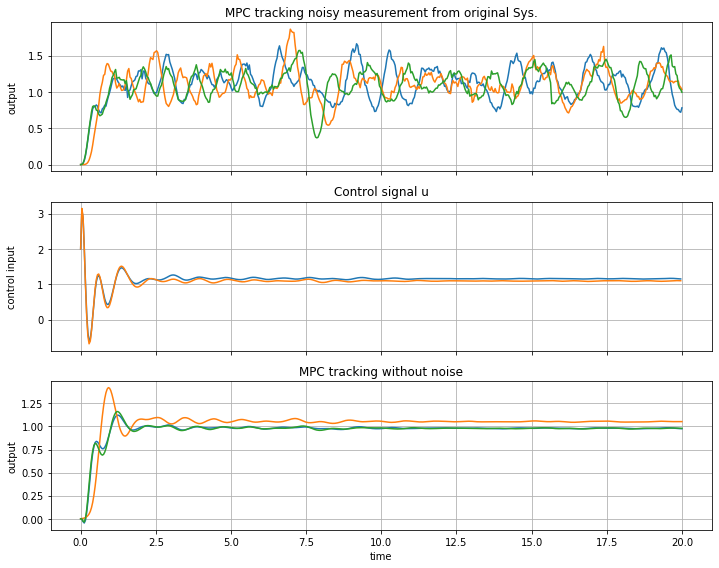

In [13]:
## results visualization ##


res_x_T = np.concatenate(res_x,axis=1)
res_u = np.array(res_u)
res_u = res_u.reshape(time.shape[0]-1,nu)

res_y = np.array(y_res)

y0 = np.zeros((ny,1))
res_y_withoutnoise = [y0]
for n in range(len(time)-1):
    temp = (Cb@res_x_T[:,n]).reshape(Cb.shape[0],1) + (Dr@res_u[n,:]).reshape(Cb.shape[0],1)
    res_y_withoutnoise.append(temp)
res_y_withoutnoise = np.array(res_y_withoutnoise).reshape(len(time),Cb.shape[0])


fig, ax = plt.subplots(3,1, figsize=(10,8), sharex=True)
ax[0].plot(time,res_y)
ax[0].set_title('MPC tracking noisy measurement from original Sys.')
ax[0].set_ylabel('output')
ax[0].grid()

ax[1].set_title('Control signal u')
ax[1].plot(time[:-1],res_u)
ax[1].set_ylabel('control input')
ax[1].grid()

ax[2].plot(time,res_y_withoutnoise)
ax[2].set_title('MPC tracking without noise')
ax[2].set_xlabel('time')
ax[2].set_ylabel('output')
ax[2].grid()

fig.align_ylabels()
fig.tight_layout()

plt.savefig('Step_response',dpi=250)